In [1]:
import numpy as np
import torch
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import cv2
from tqdm import tqdm
import tifffile
import dask.dataframe as dd
import gzip
import shutil
import h5py
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import psutil
import torchvision
from torchvision import datasets, models, transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
data_path = r"/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2024/projects/single_cell_xenium_pred/final_workspace/poc/data/"

In [4]:
df = pd.read_parquet(data_path + "spatially_var_10_patched_df.parquet")

In [5]:
len(df)

576963

In [6]:
test_df = df[df['set'] == 'test']

In [7]:
test_gene_exp = np.array(test_df['gene_exp_vector'])

In [8]:
with h5py.File(data_path + "meansize_cells.h5", 'r') as hf:
    cells_arr = np.array(hf['cells'])

In [9]:
test_cells_arr = np.zeros((len(test_df), 64, 64, 3))

In [10]:
index = 0
for i, row in tqdm(test_df.iterrows(), total = len(test_df)):
    test_cells_arr[index] = cells_arr[row['arr_index']]
    index += 1

100%|███████████████████████████████████████████████████████████████████████████████████████| 84283/84283 [00:04<00:00, 19501.42it/s]


In [11]:
class custom_dataset(Dataset):
    def __init__(self, cells, vectors, transform=None):
        self.cells = cells
        self.vectors = vectors
        self.transform = transform

    def __len__(self):
        return len(self.cells)

    def __getitem__(self, idx):
        cell = self.cells[idx]
        vector = self.vectors[idx]
        
        cell = cell / 255.0
        
        if self.transform:
            image = self.transform(image)
            
        cell = torch.tensor(cell, dtype=torch.float32).permute(2,0,1)
        vector = torch.tensor(vector, dtype=torch.float32)

        return cell, vector

In [12]:
test_dataset = custom_dataset(test_cells_arr, test_gene_exp)

In [13]:
test_loader = DataLoader(test_dataset, batch_size = 32)

In [14]:
class cell_autoencoder(nn.Module):
    def __init__(self):
        super(cell_autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2), 
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Flatten(), 
            nn.Linear(4*4*256, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, 128)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, 4*4*256),
            nn.ReLU(True),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [15]:
model = cell_autoencoder().to(device)

In [16]:
model_path = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Interns_2024/projects/single_cell_xenium_pred/final_workspace/models/"
checkpoint = torch.load(model_path + "autoencoder.pth")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [17]:
model.eval()

cell_autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=4096, out_features=512, bias=True)
    (14): ReLU(inplace=True)
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=

In [18]:
checkpoint['loss']

0.003482921291963563

In [24]:
for batch in test_loader:
    cells, exp = batch
    cells = cells.to(device)
    exp = exp.to(device)
    print(cells.shape)
    print(exp.shape)
    outputs = model(cells)
    print(outputs.shape)
    break

torch.Size([32, 3, 64, 64])
torch.Size([32, 10])
torch.Size([32, 3, 64, 64])


In [36]:
cells_display = cells

In [37]:
outputs_display = outputs

In [44]:
len(cells_display)

32

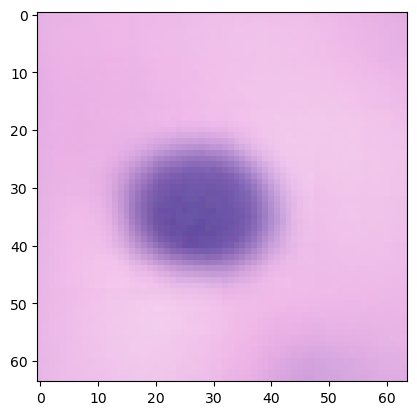

In [28]:
plt.imshow(np.transpose(outputs_display[8].cpu().detach().numpy(), (1,2,0)))

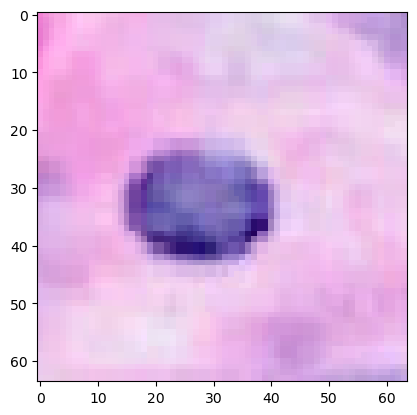

In [29]:
plt.imshow(np.transpose(cells_display[8].cpu().detach().numpy(), (1,2,0)))

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(16, 16))

for i in range(8):
    axes[i, 0].imshow(np.transpose(cells_display[i].cpu().detach().numpy(), (1,2,0)))
    axes[i, 1].imshow(np.transpose(outputs_display[i].cpu().detach().numpy(), (1,2,0)))
    axes[i, 2].imshow(np.transpose(cells_display[i+8].cpu().detach().numpy(), (1,2,0)))
    axes[i, 3].imshow(np.transpose(outputs_display[i+8].cpu().detach().numpy(), (1,2,0)))
#     axes[i, 4].imshow(np.transpose(cells_display[i+16].cpu().detach().numpy(), (1,2,0)))
#     axes[i, 5].imshow(np.transpose(outputs_display[i+16].cpu().detach().numpy(), (1,2,0)))
#     axes[i, 6].imshow(np.transpose(cells_display[i+24].cpu().detach().numpy(), (1,2,0)))
#     axes[i, 7].imshow(np.transpose(outputs_display[i+24].cpu().detach().numpy(), (1,2,0)))
    
for ax in axes.flat:
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_xticks([])
    ax.set_yticks([])

columns = ['Original', 'Reconstructed', 'Original', 'Reconstructed', 'Original', 'Reconstructed', 'Original', 'Reconstructed']
for ax, col in zip(axes[0], columns):
    ax.set_title(col, fontsize=16)
    
# for i in range(1, 4):
#     fig.axes[2*i - 1].axvline(x=64, color='black', linewidth=2)
    
plt.tight_layout()
plt.show()